In [1]:
%pip install pandas numpy torch tqdm seaborn matplotlib torchviz graphviz

You should consider upgrading via the '/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append('..')

import torch
import os
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from LOBnet.final_models import TransformerLOB, DeepLOB_Network_v2, BaselineDeepLOB
from LOBnet.orderbook import FI2010_Orderbook_Optimized

In [2]:
root_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "data", "BenchmarkDatasets_csv", "Auction", "1.Auction_Zscore", "Auction_Zscore_Training"))
window_size = 100
overlap_percent = 25  # 25% overlap between windows
num_workers = 5

In [3]:
# initialize dataset
dataset = FI2010_Orderbook_Optimized(
    root_path=root_path,
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers, 
    verbose=True
)

Processing CSV Files: 100%|██████████| 9/9 [04:26<00:00, 29.61s/it]


Raw price movement statistics:
Mean: 1.9965
Std: 0.8855
Min: 1.0000
Max: 3.0000

Label distribution:
0    10454
1     5729
2    10360
Name: count, dtype: int64


In [4]:
# create train/test splits (80/20)
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# create DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )   
)

print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 26543
Training set size: 21234
Test set size: 5309


In [5]:
# look at first batch
for batch in train_loader:
    batch_X, batch_y = batch  # unpack batch tuple
    print(f"Batch X shape: {batch_X.shape}") # should be (batch_size, 1, 100, 40)
    print(f"Batch y shape: {batch_y.shape}") # should be (batch_size, 3)
    break

Batch X shape: torch.Size([32, 1, 100, 40])
Batch y shape: torch.Size([32, 3])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training config
batch_size = 128  
learning_rate = 0.001  
num_epochs = 50

# init model and optimizer
model = TransformerLOB(y_len=3, device=device).to(device) # can switch to DeepLOB_Network_v2 or BaselineDeepLOB here
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)
criterion = nn.CrossEntropyLoss()

# save best model to savedModels/best_transformer.pth
best_val_loss = float('inf')
best_model_path = '../savedModels/best_transformer.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # training phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for batch_X, batch_y in train_batches:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        train_batches.set_postfix({'loss': loss.item()})

        _, predicted = torch.max(outputs, dim=1)
        correct_train += (predicted == batch_y.argmax(dim=1)).sum().item()
        total_train += batch_y.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Calculate epoch-level training accuracy
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # validation phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    val_batches = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

    with torch.no_grad():
        for batch_X, batch_y in val_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            val_batches.set_postfix({'loss': loss.item()})

            _, predicted = torch.max(outputs, dim=1)
            correct_val += (predicted == batch_y.argmax(dim=1)).sum().item()
            total_val += batch_y.size(0)

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # Calculate epoch-level validation accuracy
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # update learning rate
    scheduler.step(avg_val_loss)
    
    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, best_model_path)
        print(f'\nNew best model saved! Validation Loss: {avg_val_loss:.4f}')
    
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}')

/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 1.0505

Epoch 1/50:
Average Training Loss: 1.0599
Average Validation Loss: 1.0505


Epoch 2/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 1.0307

Epoch 2/50:
Average Training Loss: 1.0421
Average Validation Loss: 1.0307


Epoch 3/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.9935

Epoch 3/50:
Average Training Loss: 1.0085
Average Validation Loss: 0.9935


Epoch 4/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.9520

Epoch 4/50:
Average Training Loss: 0.9676
Average Validation Loss: 0.9520


Epoch 5/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.9255

Epoch 5/50:
Average Training Loss: 0.9399
Average Validation Loss: 0.9255


Epoch 6/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8820

Epoch 6/50:
Average Training Loss: 0.9067
Average Validation Loss: 0.8820


Epoch 7/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8452

Epoch 7/50:
Average Training Loss: 0.8712
Average Validation Loss: 0.8452


Epoch 8/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8413

Epoch 8/50:
Average Training Loss: 0.8433
Average Validation Loss: 0.8413


Epoch 9/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.8117

Epoch 9/50:
Average Training Loss: 0.8207
Average Validation Loss: 0.8117


Epoch 10/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 10/50:
Average Training Loss: 0.8030
Average Validation Loss: 0.8301


Epoch 11/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7785

Epoch 11/50:
Average Training Loss: 0.7898
Average Validation Loss: 0.7785


Epoch 12/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7774

Epoch 12/50:
Average Training Loss: 0.7741
Average Validation Loss: 0.7774


Epoch 13/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7734

Epoch 13/50:
Average Training Loss: 0.7610
Average Validation Loss: 0.7734


Epoch 14/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7704

Epoch 14/50:
Average Training Loss: 0.7524
Average Validation Loss: 0.7704


Epoch 15/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 15/50:
Average Training Loss: 0.7362
Average Validation Loss: 0.7716


Epoch 16/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7522

Epoch 16/50:
Average Training Loss: 0.7218
Average Validation Loss: 0.7522


Epoch 17/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 17/50:
Average Training Loss: 0.7083
Average Validation Loss: 0.7533


Epoch 18/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7188

Epoch 18/50:
Average Training Loss: 0.7020
Average Validation Loss: 0.7188


Epoch 19/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 19/50:
Average Training Loss: 0.6894
Average Validation Loss: 0.7371


Epoch 20/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 20/50:
Average Training Loss: 0.6797
Average Validation Loss: 0.7278


Epoch 21/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 21/50:
Average Training Loss: 0.6741
Average Validation Loss: 0.7223


Epoch 22/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7097

Epoch 22/50:
Average Training Loss: 0.6637
Average Validation Loss: 0.7097


Epoch 23/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 23/50:
Average Training Loss: 0.6568
Average Validation Loss: 0.7523


Epoch 24/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 24/50:
Average Training Loss: 0.6487
Average Validation Loss: 0.7342


Epoch 25/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 25/50:
Average Training Loss: 0.6420
Average Validation Loss: 0.7180


Epoch 26/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 26/50:
Average Training Loss: 0.6337
Average Validation Loss: 0.7230


Epoch 27/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7052

Epoch 27/50:
Average Training Loss: 0.5899
Average Validation Loss: 0.7052


Epoch 28/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 28/50:
Average Training Loss: 0.5764
Average Validation Loss: 0.7059


Epoch 29/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 29/50:
Average Training Loss: 0.5753
Average Validation Loss: 0.7098


Epoch 30/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7049

Epoch 30/50:
Average Training Loss: 0.5648
Average Validation Loss: 0.7049


Epoch 31/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


New best model saved! Validation Loss: 0.7015

Epoch 31/50:
Average Training Loss: 0.5599
Average Validation Loss: 0.7015


Epoch 32/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 32/50:
Average Training Loss: 0.5545
Average Validation Loss: 0.7313


Epoch 33/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 33/50:
Average Training Loss: 0.5518
Average Validation Loss: 0.7216


Epoch 34/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 34/50:
Average Training Loss: 0.5473
Average Validation Loss: 0.7131


Epoch 35/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 35/50:
Average Training Loss: 0.5448
Average Validation Loss: 0.7076


Epoch 36/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 36/50:
Average Training Loss: 0.5151
Average Validation Loss: 0.7241


Epoch 37/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 37/50:
Average Training Loss: 0.5114
Average Validation Loss: 0.7210


Epoch 38/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 38/50:
Average Training Loss: 0.5087
Average Validation Loss: 0.7174


Epoch 39/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 39/50:
Average Training Loss: 0.5009
Average Validation Loss: 0.7418


Epoch 40/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 40/50:
Average Training Loss: 0.4865
Average Validation Loss: 0.7404


Epoch 41/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 41/50:
Average Training Loss: 0.4836
Average Validation Loss: 0.7374


Epoch 42/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 42/50:
Average Training Loss: 0.4818
Average Validation Loss: 0.7373


Epoch 43/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 43/50:
Average Training Loss: 0.4783
Average Validation Loss: 0.7359


Epoch 44/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 44/50:
Average Training Loss: 0.4731
Average Validation Loss: 0.7456


Epoch 45/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 45/50:
Average Training Loss: 0.4764
Average Validation Loss: 0.7398


Epoch 46/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 46/50:
Average Training Loss: 0.4661
Average Validation Loss: 0.7422


Epoch 47/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 47/50:
Average Training Loss: 0.4676
Average Validation Loss: 0.7495


Epoch 48/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 48/50:
Average Training Loss: 0.4620
Average Validation Loss: 0.7513


Epoch 49/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 49/50:
Average Training Loss: 0.4591
Average Validation Loss: 0.7513


Epoch 50/50 [Train]:   0%|          | 0/664 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/166 [00:00<?, ?it/s]


Epoch 50/50:
Average Training Loss: 0.4621
Average Validation Loss: 0.7485


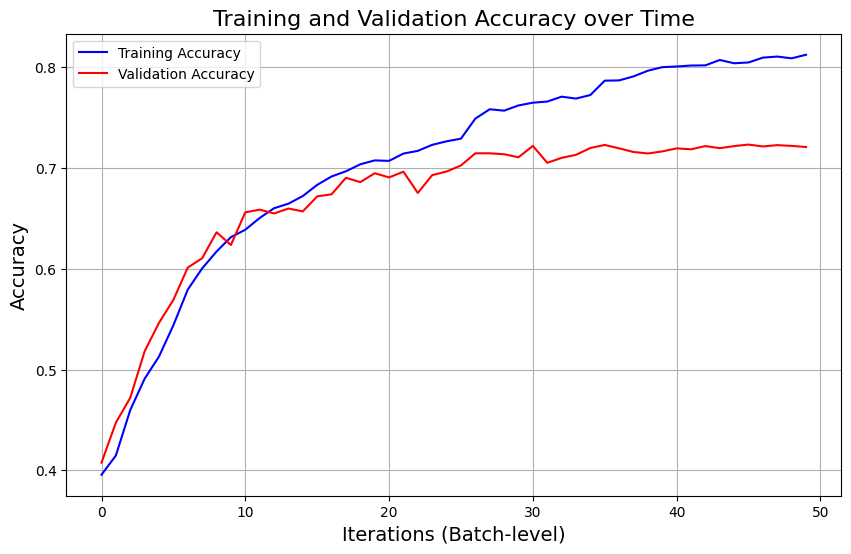

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Iterations (Batch-level)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [3]:
def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # convert one-hot encoded outputs to class predictions
            predictions = outputs.argmax(dim=1)
            true_labels = batch_y.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
    
    return all_predictions, all_labels

In [6]:
# load the saved model state if it exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '../savedModels/best_transformer.pth'
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # set to evaluation mode
else:
    print(f"No saved model found at {model_path}. Please train the model first.")
    exit()

predictions, true_labels = evaluate_model(model, test_loader, device)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['No Movement', 'Up', 'Down']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Movement', 'Up', 'Down'],
            yticklabels=['No Movement', 'Up', 'Down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Loading saved model from ../savedModels/best_transformer.pth


/var/folders/6y/rz_n_6x924d63ryw6s3z5jch0000gn/T/ipykernel_1340/2397171367.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


NameError: name 'model' is not defined

In [10]:
root_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "data", "BenchmarkDatasets_csv", "Auction", "1.Auction_Zscore", "Auction_Zscore_Testing"))
window_size = 100
overlap_percent = 25  # 25% overlap between windows
num_workers = 5

In [11]:
test_dataset = FI2010_Orderbook_Optimized(
    root_path=root_path,
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers, 
    verbose=True
)

Processing CSV Files: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


Raw price movement statistics:
Mean: 1.9958
Std: 0.8641
Min: 1.0000
Max: 3.0000

Label distribution:
0    2057
1    1388
2    2034
Name: count, dtype: int64


In [20]:
batch_size = 32
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )
)

In [7]:
predictions, true_labels = evaluate_model(model, test_loader, device)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['No Movement', 'Up', 'Down']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Up', 'No Movement', 'Down'],
            yticklabels=['Up', 'No Movement', 'Down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'evaluate_model' is not defined